In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv
import dask.bag as db
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.utils import shuffle
from sklearn import metrics
from hkfold import HKFold, train_test_split
from scipy.optimize import fmin_cg

In [2]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[(df.ds != 201603) & (df.phi_m.notnull())]
df = df.sort_values(['ds', 'tt'])
df = df.dropna()

lets start with a baseline. data doesnt follow the functions given in the literature, so while I fix it we can change those functions to fit the data. given the definition of $\phi_m$ for $\xi>0$:

$$
\phi_m(\xi)=a+b\xi
$$

whose derivatives are trivial. for $\xi<0$ we have

$$
\phi_m(\xi)=(1+c\xi)^d
$$

whose derivatives are

$$
\frac{\partial \phi_m}{\partial c}=\xi d(1+c\xi)^{d-1}
$$

$$
\frac{\partial \phi_m}{\partial d}=(1+c\xi)^d\ln(1+c\xi)
$$

considering the usual least squares with l2 regularization we have the loss function

$$
E=\frac{1}{N}\sum_i(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))^2+\frac{1}{2}\sum_p p^2
$$

and its derivative with respect to the parameter $p$

$$
\frac{\partial E}{\partial p}=\frac{2}{N}\sum_i\frac{\partial}{\partial p}\phi_m(\xi_i,p)\cdot(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))+p
$$

In [14]:
def phim(zL, a, b, c, d):
    mask = zL >= 0
    yy = np.zeros(len(zL))
    yy[mask] = a + b * zL[mask]
    yy[~mask] = np.power(1 + c * zL[~mask], d)
    assert all(np.isfinite(zL))
    assert all(np.isfinite(yy)), (a, b, c, d)
    return yy


def phim_prime(zL, a, b, c, d):
    dpda, dpdb, dpdc, dpdd = np.zeros((4, len(zL)))
    
    pos, neg = zL >= 0, zL < 0
    
    dpda[pos] = 1
    dpdb[pos] = zL[pos]
    
    inner = 1 + c * zL[neg]
    dpdc[neg] = zL[neg] * d * np.power(inner, d - 1)
    dpdd[neg] = np.log(inner) * np.power(inner, d)

    return dpda, dpdb, dpdc, dpdd

In [37]:
train_idx, test_idx = next(HKFold(KFold(250, shuffle=True), h=int(1 * 60 / 10)).split(df))

train_x, train_y = df.zL.iloc[train_idx], df.phi_m.iloc[train_idx]
test_x, test_y = df.zL.iloc[test_idx], df.phi_m.iloc[test_idx]

#train_x, test_x, train_y, test_y = train_test_split(df.zL_m.values, df.phi_m.values,
#                                                    h=int(24 * 60 / 10), test_size=5000)

print('training with %d samples, testing with %d' % (len(train_x), len(test_x)))

training with 1262534 samples, testing with 5321


In [40]:
def fmin(params, xx, yy, regu):
    preds = phim(xx, *params)
    return np.mean((yy - preds)**2)


def fmingrad(params, xx, yy, regu):
    preds = phim(xx, *params)
    der = phim_prime(xx, *params)
    
    grads = []
    for par, parpr in zip(params, der):
        grads.append(2 * np.mean((preds - yy) * parpr) + regu * par)
    return np.array(grads)


params = fmin_cg(fmin, [1, 4.8, -19.3, -0.25], fmingrad, args=(train_x, train_y, 0.1))
params

         Current function value: 0.550363
         Iterations: 6
         Function evaluations: 244
         Gradient evaluations: 232


array([  1.46980757,   1.28824661, -11.79736724,  -0.11859308])

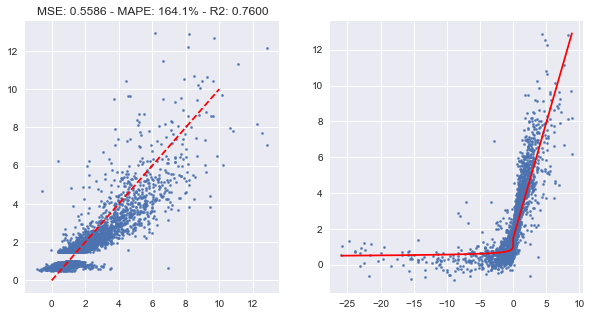

In [42]:
pred = phim(test_x, *params)
rmse = np.mean(np.power(pred - test_y, 2))
mape = np.mean(np.abs((pred - test_y) / test_y)) * 100
r2s = metrics.r2_score(test_y, pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_y, pred, s=5)
plt.title('MSE: %.4f - MAPE: %.1f%% - R2: %.4f' % (rmse, mape, r2s))
plt.plot([0, 10], [0, 10], 'r--')

plt.subplot(1, 2, 2)
plt.scatter(test_x, test_y, s=5)
plt.plot(test_x.sort_values(), phim(test_x.sort_values(), *params), 'r')
plt.show()

In [6]:
df

,ds,year,month,daym,hday,tt,air_dens,H,LE,ustar,...,ITA002,IP0,dewpoint,spec_hum,rel_hum,press,rain,co2flux,soilheat,netrad
2333952,200303,2003,3,0,0.000000,0.000000,0.266591,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.096699,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333953,200303,2003,3,0,0.000000,0.000000,0.259949,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.294352,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333955,200303,2003,3,0,0.000000,0.000000,0.260408,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.280362,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333956,200303,2003,3,0,0.166667,0.166667,0.266591,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.096699,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333957,200303,2003,3,0,0.166667,0.166667,0.259949,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.294352,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333959,200303,2003,3,0,0.166667,0.166667,0.260408,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.280362,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333960,200303,2003,3,0,0.333333,0.333333,0.266591,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.096699,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333961,200303,2003,3,0,0.333333,0.333333,0.259949,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.294352,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333963,200303,2003,3,0,0.333333,0.333333,0.260408,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.280362,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248
2333964,200303,2003,3,0,0.500000,0.500000,0.266591,-26.600386,12.94590,0.426092,...,2.0,3.0,280.542175,6.096699,94.007423,1016.400024,0.002,0.077802,6.800237,-6.854248


In [3]:
def test(model, grid, features, target):
    results = []
    outer_cv = HKFold(KFold(5), h=int(7 * 24 * 60 / 10))

    for oi, (dev_idx, test_idx) in enumerate(outer_cv.split(df)):
        inner_cv = HKFold(KFold(5), h=int(7 * 24 * 60 / 10))

        gs = GridSearchCV(
            model, grid, n_jobs=7, cv=inner_cv,
            scoring='neg_mean_squared_error',
            verbose=1
        )

        train_x, train_y = df[features].iloc[dev_idx], df[target].iloc[dev_idx]
        mean_x, std_x = train_x.mean(), train_x.std()
        mean_y, std_y = train_y.mean(), train_y.std()
        
        train_x = (train_x - mean_x) / std_x
        train_y = (train_y - mean_y) / std_y

        gs.fit(train_x, train_y)

        test_x, test_y = df[features].iloc[test_idx], df[target].iloc[test_idx]
        test_x = (test_x - mean_x) / std_x
        test_y = (test_y - mean_y) / std_y

        y_pred = gs.best_estimator_.predict(test_x)

        results.append((
            metrics.explained_variance_score(test_y, y_pred),
            metrics.mean_absolute_error(test_y, y_pred),
            metrics.mean_squared_error(test_y, y_pred),
            metrics.median_absolute_error(test_y, y_pred),
            metrics.r2_score(test_y, y_pred),
            np.mean(np.abs((test_y - y_pred) / test_y)) * 100,
        ))

    return pd.DataFrame(results, columns=[
        'explained_variance_score',
        'mean_absolute_error',
        'mean_squared_error',
        'median_absolute_error',
        'r2_score',
        'mean_percent_error'
    ]).T, y_pred, test_y

In [4]:
features = [
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain',
    'air_dens', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z',
]

target = 'phi_m'

In [5]:
knn_res, ypred, ytrue = test(RandomForestRegressor(),  {
    'n_estimators': [100, 500, 1000],
    'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [10, 50, 100, 500, 1000],
    'min_samples_leaf': [10, 50, 100, 500, 1000],
}, features, target)
knn_res

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


KeyboardInterrupt: 

In [ ]:
plt.scatter(ytrue, ypred, s=10)
plt.plot([0, 10], [0, 10], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [21]:
lrres, ypred, ytrue = test(Ridge(), {
    'alpha': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
}, features, target)
lrres

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:   10.7s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:   10.2s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:   10.4s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:   10.6s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:   10.3s finished


,0,1,2,3,4
explained_variance_score,-0.420622,0.337201,0.331080,0.219603,0.341957
mean_absolute_error,0.593216,0.523979,0.564926,0.592999,0.580627
mean_squared_error,1.395565,0.616840,0.667836,0.746078,0.765320
median_absolute_error,0.400621,0.367673,0.403803,0.417153,0.392300
r2_score,-0.441824,0.334673,0.330396,0.214867,0.341701
mean_percent_error,498.647735,334.681807,687.991454,413.294000,485.561577


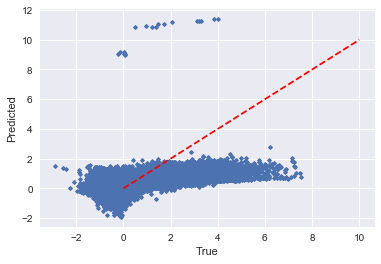

In [22]:
plt.scatter(ytrue, ypred, s=10)
plt.plot([0, 10], [0, 10], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()